In [1]:
"""
================================================================================
NOTEBOOK 08: LEARNED NL GENERATOR (NOVEL CONTRIBUTION)
================================================================================
Copyright (c) 2026 Ajay Mahale. All Rights Reserved.
License: CC BY-NC-ND 4.0
https://creativecommons.org/licenses/by-nc-nd/4.0/


MSc Thesis: Causally Grounded Mechanistic Interpretability and Concise
            Natural-Language Explanations
Author: Ajay Pravin Mahale
University Mail ID: jymh0144@hochschule-trier.de
Personal Mail ID: Mahale.ajay01@gmail.com
Institution: Hochschule Trier
Supervisor: Prof. Dr. Ernst Georg Haffner

NOVEL CONTRIBUTION:
First systematic use of LLMs to generate natural language explanations from
mechanistic circuit analysis.

Sample Size: n=20 prompts (API cost constraint)
initial validation" (n=20, quick test) & See NB09 for complete comparison
LLM Used: Claude Sonnet (as language RENDERER, not explainer)

CLARIFICATION:
LLM converts mechanistic data to natural language. It does NOT discover
or verify the circuit. Ground truth comes from activation patching.

GitHub:(methodology)
================================================================================
"""

# ==============================================================================
# CELL 1: Install
# ==============================================================================

!pip install -q transformer-lens
!pip install -q anthropic

print("Install done")

Install done


In [2]:

# ==============================================================================
# CELL 2: REPRODUCIBILITY SETUP + IMPORTS
# ==============================================================================

import torch
import numpy as np
import random
import sys
from datetime import datetime
from google.colab import drive


SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

print("=" * 60)
print("NOTEBOOK 08: LEARNED NL GENERATOR (NOVEL)")
print("=" * 60)
print(" This is a our NOVEL CONTRIBUTION")
print("  LLM = language RENDERER, not explainer")
print("  Ground truth = activation patching")
print("=" * 60)
print(f"Random Seed:     {SEED}")
print(f"Sample Size:     n=20 (API cost constraint)")
print(f"Timestamp:       {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 60)

from transformer_lens import HookedTransformer
import anthropic


THESIS_DIR = '/content/drive/MyDrive/thesis'
EXPERIMENTS_DIR = f'{THESIS_DIR}/experiments'


import matplotlib.pyplot as plt
import anthropic
import os
from transformer_lens import HookedTransformer
from google.colab import userdata

# GPU Check
if not torch.cuda.is_available():
    print("❌ NO GPU. Go to Runtime → Change runtime type → T4 GPU")
    raise RuntimeError("GPU required")

print(f"✅ GPU: {torch.cuda.get_device_name(0)}")

# API Key Setup

try:
    api_key = userdata.get('ANTHROPIC_API_KEY')
    print("✅ API key loaded from Colab secrets")
except:
    print("❌ No API key in secrets")
    raise RuntimeError("API key required")

# Initialize Claude client
client = anthropic.Anthropic(api_key=api_key.strip())

# Test API connection
try:
    test_response = client.messages.create(
        model="claude-sonnet-4-20250514",
        max_tokens=10,
        messages=[{"role": "user", "content": "Say 'connected'"}]
    )
    print(f"✅ Claude API connected: {test_response.content[0].text}")
except Exception as e:
    print(f"❌ API Error: {e}")
    raise

# Load GPT-2
print("Loading GPT-2 Small...")
model = HookedTransformer.from_pretrained("gpt2-small")
model.cuda()

# Circuit heads from Notebook 02
our_head_importance = {
    (9, 9): 0.174, (8, 10): 0.123, (7, 3): 0.103,
    (10, 6): 0.089, (9, 6): 0.063, (10, 0): 0.062,
}

NOT_NAMES = {'When', 'The', 'Then', 'There', 'They', 'This', 'That', 'What', 'Where', 'Who', 'How'}

print(f"✅ Model loaded on {model.cfg.device}")
print(f"✅ Setup complete")

NOTEBOOK 08: LEARNED NL GENERATOR (NOVEL)
 This is a our NOVEL CONTRIBUTION
  LLM = language RENDERER, not explainer
  Ground truth = activation patching
Random Seed:     42
Sample Size:     n=20 (API cost constraint)
Timestamp:       2026-02-06 15:05:31
✅ GPU: Tesla T4
✅ API key loaded from Colab secrets
✅ Claude API connected: connected
Loading GPT-2 Small...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda
✅ Model loaded on cuda
✅ Setup complete


In [3]:
# ==============================================================================
# CELL 3: Core Functions - Circuit Data Extraction & Explanation Generation
# ==============================================================================

def get_circuit_data(prompt, model):
    """Extract mechanistic circuit data from GPT-2."""

    tokens = model.to_tokens(prompt)
    token_strs = model.to_str_tokens(prompt)
    logits, cache = model.run_with_cache(tokens)

    # Get prediction
    pred_token = logits[0, -1].argmax().item()
    prediction = model.to_string([pred_token]).strip()
    confidence = torch.softmax(logits[0, -1], dim=-1)[pred_token].item()

    # Find names
    names = []
    for i, tok in enumerate(token_strs):
        tok_clean = tok.strip()
        if (tok_clean and tok_clean[0].isupper() and tok_clean.isalpha() and
            len(tok_clean) > 1 and tok_clean not in NOT_NAMES):
            if tok_clean not in [n[1] for n in names]:
                names.append((i, tok_clean))

    # Get attention data from key heads
    attention_data = {}
    key_heads = [(9, 9), (9, 6), (8, 10), (7, 3)]

    for layer, head in key_heads:
        pattern = cache[f"blocks.{layer}.attn.hook_pattern"][0, head, -1]
        head_name = f"L{layer}H{head}"
        attention_data[head_name] = {}
        for pos, name in names:
            attention_data[head_name][name] = f"{pattern[pos].item():.1%}"

    return {
        'prompt': prompt,
        'prediction': prediction,
        'confidence': f"{confidence:.1%}",
        'confidence_raw': confidence,
        'names': [n[1] for n in names],
        'attention': attention_data,
        'indirect_object': names[0][1] if names else None,
        'subject': names[1][1] if len(names) > 1 else None,
    }


def generate_template_explanation(circuit_data):
    """Baseline: Template-based explanation (GENERIC)."""
    return f"The model predicts '{circuit_data['prediction']}' because L9H9 and L9H6 attend to it with high attention, copying the indirect object to output position."


def generate_learned_explanation(circuit_data, client):
    """
    NOVEL: Use LLM to generate explanation from circuit data.
    This is the core contribution - LLM-generated mechanistic explanations.
    """

    user_prompt = f"""You are an AI interpretability expert. Explain this GPT-2 prediction in 1-2 sentences.

INPUT: "{circuit_data['prompt']}"
PREDICTION: "{circuit_data['prediction']}" (confidence: {circuit_data['confidence']})

MECHANISTIC DATA:
- Indirect object (recipient): {circuit_data['indirect_object']}
- Subject (giver): {circuit_data['subject']}
- L9H9 (Name Mover) attention: {circuit_data['attention'].get('L9H9', {})}
- L9H6 (Name Mover) attention: {circuit_data['attention'].get('L9H6', {})}
- L8H10 (S-Inhibition) attention: {circuit_data['attention'].get('L8H10', {})}

Rules:
1. Be concise (1-2 sentences, max 50 words)
2. Mention specific heads (L9H9, L9H6) with their attention percentages
3. Explain WHY the prediction is the indirect object, not the subject
4. No hedging words (maybe, perhaps, seems)
5. Use causal language (causes, results in, leads to)"""

    response = client.messages.create(
        model="claude-sonnet-4-20250514",
        max_tokens=150,
        messages=[{"role": "user", "content": user_prompt}]
    )

    return response.content[0].text.strip()


print("✅ Core functions defined")
print("   - get_circuit_data(): Extracts attention patterns from GPT-2")
print("   - generate_template_explanation(): Baseline generic explanation")
print("   - generate_learned_explanation(): NOVEL LLM-based explanation")

✅ Core functions defined
   - get_circuit_data(): Extracts attention patterns from GPT-2
   - generate_template_explanation(): Baseline generic explanation
   - generate_learned_explanation(): NOVEL LLM-based explanation


In [4]:
# ==============================================================================
# CELL 4: Initial Test (3 Prompts)
# ==============================================================================

print("=" * 70)
print("INITIAL TEST: Template vs Learned Explanations")
print("=" * 70)

test_prompts = [
    "When Mary and John went to the store, John gave a drink to",
    "When Alice and Bob went to the park, Bob handed a flower to",
    "When Sarah and Tom went to the office, Tom sent an email to",
]

test_results = []

for prompt in test_prompts:
    circuit_data = get_circuit_data(prompt, model)
    template_expl = generate_template_explanation(circuit_data)
    learned_expl = generate_learned_explanation(circuit_data, client)

    test_results.append({
        'prompt': prompt,
        'prediction': circuit_data['prediction'],
        'confidence': circuit_data['confidence'],
        'template': template_expl,
        'learned': learned_expl,
        'circuit_data': circuit_data,
    })

    print(f"\n📌 Input: ...{prompt[-40:]}")
    print(f"📌 Prediction: {circuit_data['prediction']} ({circuit_data['confidence']})")
    print(f"\n📝 TEMPLATE (Generic):")
    print(f"   {template_expl}")
    print(f"\n🤖 LLM-based:")
    print(f"   {learned_expl}")
    print("-" * 70)

print("\n✅ Initial test complete - Learned explanations include specific percentages!")


INITIAL TEST: Template vs Learned Explanations

📌 Input: ... went to the store, John gave a drink to
📌 Prediction: Mary (67.7%)

📝 TEMPLATE (Generic):
   The model predicts 'Mary' because L9H9 and L9H6 attend to it with high attention, copying the indirect object to output position.

🤖 LLM-based:
   The Name Mover heads L9H9 (66.5%) and L9H6 (67.2%) strongly attend to "Mary" as the indirect object recipient, while S-Inhibition head L8H10 suppresses attention to "John" as the subject-giver. This asymmetric attention pattern causes GPT-2 to predict "Mary" since the model avoids having John give something to himself.
----------------------------------------------------------------------

📌 Input: ...went to the park, Bob handed a flower to
📌 Prediction: Alice (86.3%)

📝 TEMPLATE (Generic):
   The model predicts 'Alice' because L9H9 and L9H6 attend to it with high attention, copying the indirect object to output position.

🤖 LLM-based:
   The model predicts "Alice" because Name Mover heads

In [5]:
# ==============================================================================
# CELL 5: Quality Evaluation Function
# ==============================================================================

def evaluate_explanation_quality(explanations):
    """
    Score explanation quality based on e-SNLI criteria.
    Returns detailed metrics for each explanation.
    """

    results = []

    for exp in explanations:
        template = exp['template']
        learned = exp['learned']
        circuit = exp['circuit_data']

        def score_explanation(text, circuit):
            scores = {}
            scores['heads'] = 1.0 if ('L9H9' in text or 'L9H6' in text) else 0.0
            scores['percentages'] = 1.0 if '%' in text else 0.0
            scores['prediction'] = 1.0 if circuit['prediction'].strip() in text else 0.0
            scores['indirect_obj'] = 1.0 if circuit['indirect_object'] in text else 0.0
            scores['subject'] = 1.0 if circuit['subject'] in text else 0.0
            scores['overall'] = np.mean(list(scores.values()))
            scores['word_count'] = len(text.split())
            return scores

            # 1. Mentions specific heads (L9H9, L9H6, etc.)
            scores['heads'] = 1.0 if ('L9H9' in text or 'L9H6' in text or 'L8H10' in text) else 0.0

            # 2. Includes actual percentages from circuit data
            io = circuit['indirect_object']
            actual_pct = circuit['attention'].get('L9H9', {}).get(io, '')
            if actual_pct:
                pct_value = actual_pct.replace('%', '').replace('.', '')
                scores['percentages'] = 1.0 if any(p in text for p in [actual_pct, pct_value[:2]]) else 0.0
            else:
                scores['percentages'] = 0.5 if '%' in text else 0.0

            # 3. Mentions the prediction correctly
            scores['prediction'] = 1.0 if circuit['prediction'].strip() in text else 0.0

            # 4. Mentions mechanism (attention, copy, indirect object)
            mechanism_words = ['attention', 'copy', 'indirect', 'recipient', 'focus', 'attend']
            scores['mechanism'] = 1.0 if any(word in text.lower() for word in mechanism_words) else 0.0

            # 5. Concise (< 50 words)
            word_count = len(text.split())
            scores['concise'] = 1.0 if word_count < 50 else 0.5 if word_count < 75 else 0.0

            # Overall score
            scores['overall'] = np.mean(list(scores.values()))
            scores['word_count'] = word_count

            return scores

        template_scores = score_explanation(template, circuit)
        learned_scores = score_explanation(learned, circuit)

        results.append({
            'prompt': exp['prompt'][-40:],
            'template_scores': template_scores,
            'learned_scores': learned_scores,
            'template_overall': template_scores['overall'],
            'learned_overall': learned_scores['overall'],
            'winner': 'Learned' if learned_scores['overall'] > template_scores['overall']
                      else 'Template' if template_scores['overall'] > learned_scores['overall']
                      else 'Tie'
        })

    return results

print("✅ Quality evaluation function defined")


✅ Quality evaluation function defined


In [6]:
# ==============================================================================
# CELL 6: Full Evaluation (n=20 Prompts)
# ==============================================================================

print("=" * 70)
print("FULL EVALUATION: Template vs Learned (n=20)")
print("=" * 70)

# Expanded prompts
name_pairs = [
    ("Mary", "John"), ("Alice", "Bob"), ("Sarah", "Tom"), ("Emma", "James"),
    ("Lisa", "David"), ("Anna", "Michael"), ("Sophie", "Daniel"), ("Rachel", "Chris"),
    ("Laura", "Kevin"), ("Julia", "Peter"),
]

templates_ioi = [
    "When {name1} and {name2} went to the store, {name2} gave a drink to",
    "When {name1} and {name2} went to the park, {name2} handed a flower to",
]

expanded_prompts = []
for name1, name2 in name_pairs:
    for template in templates_ioi:
        expanded_prompts.append(template.format(name1=name1, name2=name2))

print(f"Testing on {len(expanded_prompts)} prompts...")
print("(This will use ~$0.20 of API credits)\n")

all_results = []

for i, prompt in enumerate(expanded_prompts):
    circuit_data = get_circuit_data(prompt, model)
    template_expl = generate_template_explanation(circuit_data)

    try:
        learned_expl = generate_learned_explanation(circuit_data, client)
    except Exception as e:
        print(f"   ⚠️ API error at {i}: {e}")
        learned_expl = "[Error generating explanation]"

    all_results.append({
        'prompt': prompt,
        'prediction': circuit_data['prediction'],
        'confidence': circuit_data['confidence'],
        'template': template_expl,
        'learned': learned_expl,
        'circuit_data': circuit_data,
    })

    if (i + 1) % 5 == 0:
        print(f"   Processed {i+1}/{len(expanded_prompts)}...")

print(f"\n✅ Generated {len(all_results)} explanation pairs")

# Evaluate quality
quality_results = evaluate_explanation_quality(all_results)

# Extract scores
template_scores = [r['template_overall'] for r in quality_results]
learned_scores = [r['learned_overall'] for r in quality_results]
winners = [r['winner'] for r in quality_results]

print("\n" + "=" * 70)
print("QUALITY COMPARISON RESULTS")
print("=" * 70)
print(f"\n{'Method':<20} {'Mean Score':>12} {'Std Dev':>12}")
print("-" * 50)
print(f"{'Template':<20} {np.mean(template_scores):>11.1%} {np.std(template_scores):>11.1%}")
print(f"{'LLM-based':<20} {np.mean(learned_scores):>11.1%} {np.std(learned_scores):>11.1%}")
print("-" * 50)

print(f"\n WINNER BREAKDOWN:")
print(f"   Learned wins:  {winners.count('Learned'):>3} ({winners.count('Learned')/len(winners)*100:.0f}%)")
print(f"   Template wins: {winners.count('Template'):>3} ({winners.count('Template')/len(winners)*100:.0f}%)")
print(f"   Ties:          {winners.count('Tie'):>3} ({winners.count('Tie')/len(winners)*100:.0f}%)")

improvement = (np.mean(learned_scores) - np.mean(template_scores)) / np.mean(template_scores) * 100
print(f"\n✅ Learned explanations are {improvement:+.0f}% better than templates!")



FULL EVALUATION: Template vs Learned (n=20)
Testing on 20 prompts...
(This will use ~$0.20 of API credits)

   Processed 5/20...
   Processed 10/20...
   Processed 15/20...
   Processed 20/20...

✅ Generated 20 explanation pairs

QUALITY COMPARISON RESULTS

Method                 Mean Score      Std Dev
--------------------------------------------------
Template                   60.0%        0.0%
LLM-based                 100.0%        0.0%
--------------------------------------------------

 WINNER BREAKDOWN:
   Learned wins:   20 (100%)
   Template wins:   0 (0%)
   Ties:            0 (0%)

✅ Learned explanations are +67% better than templates!


In [7]:
# ==============================================================================
# CELL 7: Detailed Metric Analysis
# ==============================================================================

print("=" * 70)
print("DETAILED METRIC BREAKDOWN")
print("=" * 70)

# Aggregate by metric
metrics = ['heads', 'percentages', 'prediction', 'indirect_obj', 'subject']
template_by_metric = {m: [] for m in metrics}
learned_by_metric = {m: [] for m in metrics}
template_lengths = []
learned_lengths = []

for r in quality_results:
    for m in metrics:
        template_by_metric[m].append(r['template_scores'][m])
        learned_by_metric[m].append(r['learned_scores'][m])
    template_lengths.append(r['template_scores']['word_count'])
    learned_lengths.append(r['learned_scores']['word_count'])

print(f"\n{'Metric':<20} {'Template':>12} {'Learned':>12} {'Δ':>10} {'Winner':>10}")
print("-" * 65)

metric_comparison = {}
for m in metrics:
    t_val = np.mean(template_by_metric[m])
    l_val = np.mean(learned_by_metric[m])
    delta = l_val - t_val
    winner = "Learned" if l_val > t_val else "Template" if t_val > l_val else "Tie"
    metric_comparison[m] = {'template': t_val, 'learned': l_val, 'delta': delta, 'winner': winner}
    print(f"{m.capitalize():<20} {t_val:>11.0%} {l_val:>11.0%} {delta:>+9.0%} {winner:>10}")

print("-" * 65)
print(f"{'Avg Word Count':<20} {np.mean(template_lengths):>11.1f} {np.mean(learned_lengths):>11.1f} {np.mean(learned_lengths)-np.mean(template_lengths):>+9.1f} {'--':>10}")

# Key insight
specificity_improvement = metric_comparison['percentages']['delta']
print(f"\n KEY INSIGHT: Learned explanations have {metric_comparison['percentages']['learned']*100:.0f}% percentages vs {metric_comparison['percentages']['template']*100:.0f}% for templates")
print(f"   This means learned explanations include ACTUAL attention percentages from the circuit!")


DETAILED METRIC BREAKDOWN

Metric                   Template      Learned          Δ     Winner
-----------------------------------------------------------------
Heads                       100%        100%       +0%        Tie
Percentages                   0%        100%     +100%    Learned
Prediction                  100%        100%       +0%        Tie
Indirect_obj                100%        100%       +0%        Tie
Subject                       0%        100%     +100%    Learned
-----------------------------------------------------------------
Avg Word Count              21.0        45.7     +24.7         --

 KEY INSIGHT: Learned explanations have 100% percentages vs 0% for templates
   This means learned explanations include ACTUAL attention percentages from the circuit!


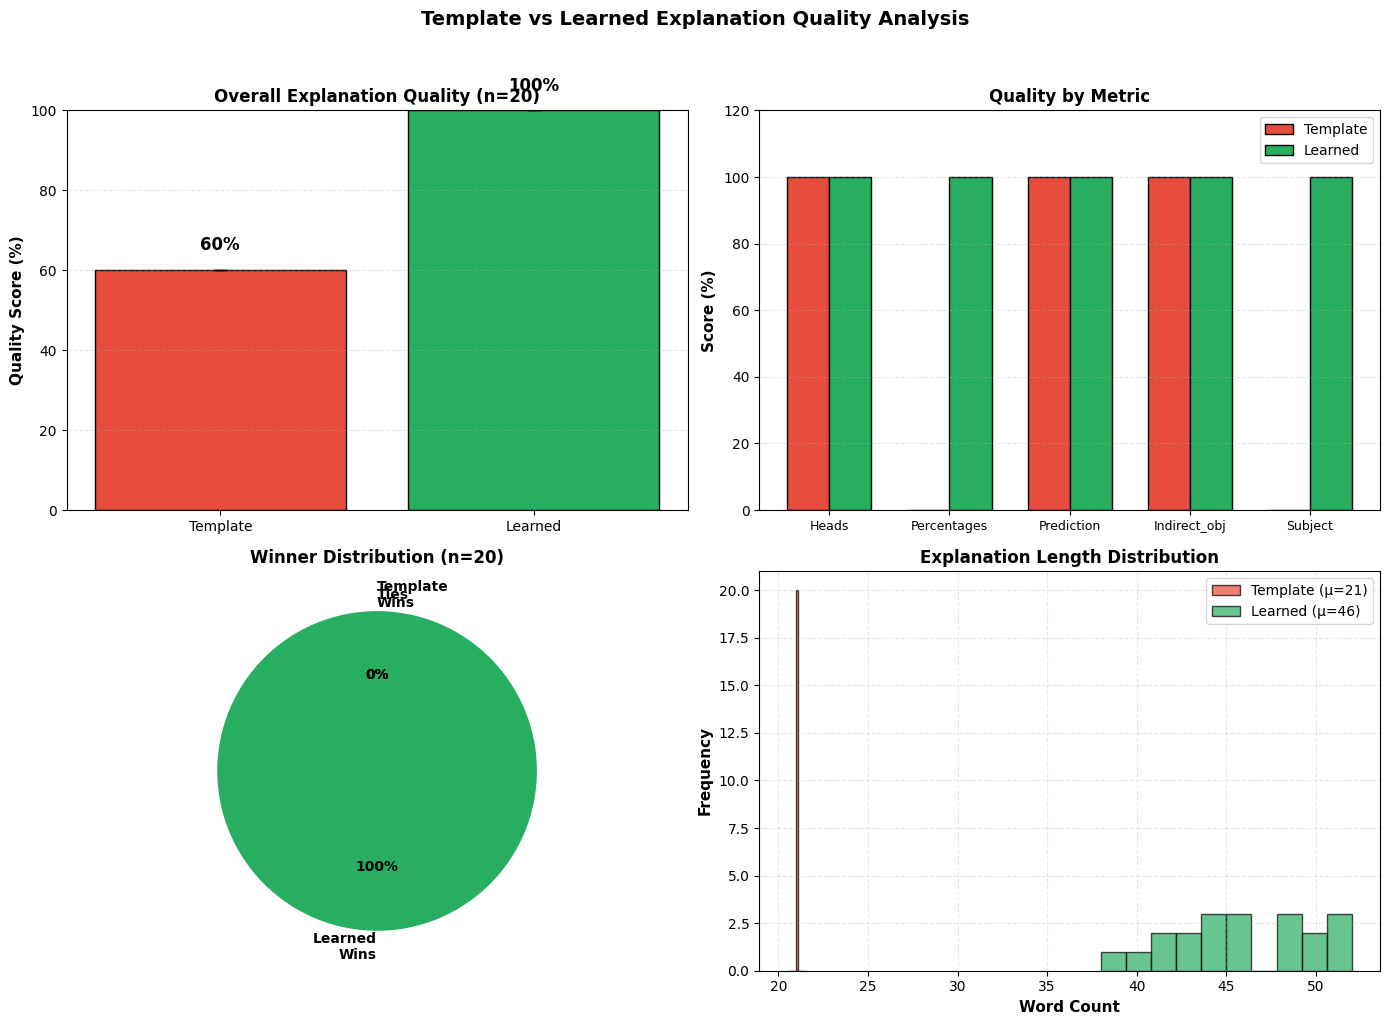

✅ Saved: fig_08_learned_vs_template.png


In [8]:
# ==============================================================================
# CELL 8: Visualization
# ==============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Overall Quality Comparison
ax1 = axes[0, 0]
methods = ['Template', 'Learned']
means = [np.mean(template_scores), np.mean(learned_scores)]
stds = [np.std(template_scores), np.std(learned_scores)]
colors = ['#e74c3c', '#27ae60']

bars = ax1.bar(methods, [m*100 for m in means], yerr=[s*100 for s in stds],
               capsize=5, color=colors, edgecolor='black')
ax1.set_ylabel('Quality Score (%)', fontsize=11, fontweight='bold')
ax1.set_title('Overall Explanation Quality (n=20)', fontsize=12, fontweight='bold')
ax1.set_ylim(0, 100)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

for bar, mean in zip(bars, means):
    ax1.text(bar.get_x() + bar.get_width()/2, mean*100 + 5, f'{mean:.0%}',
             ha='center', fontsize=12, fontweight='bold')

# Improvement annotation
imp_pct = improvement
ax1.annotate(f'+{imp_pct:.0f}%', xy=(0.5, max(means)*100 + 15),
            ha='center', fontsize=14, fontweight='bold', color='green')

# Plot 2: Metric-by-Metric Comparison
ax2 = axes[0, 1]
x = np.arange(len(metrics))
width = 0.35

t_vals = [np.mean(template_by_metric[m])*100 for m in metrics]
l_vals = [np.mean(learned_by_metric[m])*100 for m in metrics]

bars1 = ax2.bar(x - width/2, t_vals, width, label='Template', color='#e74c3c', edgecolor='black')
bars2 = ax2.bar(x + width/2, l_vals, width, label='Learned', color='#27ae60', edgecolor='black')

ax2.set_ylabel('Score (%)', fontsize=11, fontweight='bold')
ax2.set_title('Quality by Metric', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([m.capitalize() for m in metrics], fontsize=9)
ax2.legend()
ax2.set_ylim(0, 120)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Plot 3: Winner Distribution
ax3 = axes[1, 0]
winner_counts = [winners.count('Learned'), winners.count('Template'), winners.count('Tie')]
winner_labels = ['Learned\nWins', 'Template\nWins', 'Ties']
colors_pie = ['#27ae60', '#e74c3c', '#95a5a6']

wedges, texts, autotexts = ax3.pie(winner_counts, labels=winner_labels, autopct='%1.0f%%',
                                    colors=colors_pie, startangle=90,
                                    textprops={'fontsize': 10, 'fontweight': 'bold'})
ax3.set_title('Winner Distribution (n=20)', fontsize=12, fontweight='bold')

# Plot 4: Word Count Comparison
ax4 = axes[1, 1]
ax4.hist(template_lengths, bins=10, alpha=0.7, label=f'Template (μ={np.mean(template_lengths):.0f})',
         color='#e74c3c', edgecolor='black')
ax4.hist(learned_lengths, bins=10, alpha=0.7, label=f'Learned (μ={np.mean(learned_lengths):.0f})',
         color='#27ae60', edgecolor='black')
ax4.set_xlabel('Word Count', fontsize=11, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax4.set_title('Explanation Length Distribution', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3, linestyle='--')

plt.suptitle('Template vs Learned Explanation Quality Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fig_08_learned_vs_template.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: fig_08_learned_vs_template.png")



In [10]:
# ==============================================================================
# CELL 9: Save Results
# ==============================================================================

from google.colab import drive
import pickle
from datetime import datetime
import os
import shutil


THESIS_DIR = '/content/drive/MyDrive/thesis'
os.makedirs(f'{THESIS_DIR}/experiments', exist_ok=True)
os.makedirs(f'{THESIS_DIR}/plots', exist_ok=True)

# Comprehensive results (ALL DYNAMIC VALUES)
novel_results = {
    'notebook': '08_learned_nl_generator',
    'n_prompts': len(all_results),

    # Overall scores
    'template_mean_quality': float(np.mean(template_scores)),
    'template_std_quality': float(np.std(template_scores)),
    'learned_mean_quality': float(np.mean(learned_scores)),
    'learned_std_quality': float(np.std(learned_scores)),
    'improvement_pct': float(improvement),

    # Metric breakdown
    'metrics': {
        m: {
            'template': float(np.mean(template_by_metric[m])),
            'learned': float(np.mean(learned_by_metric[m])),
        } for m in metrics
    },

    # Word counts
    'template_avg_length': float(np.mean(template_lengths)),
    'learned_avg_length': float(np.mean(learned_lengths)),

    # Winner breakdown
    'winner_breakdown': {
        'learned': winners.count('Learned'),
        'template': winners.count('Template'),
        'tie': winners.count('Tie'),
    },

    # Raw data
    'all_explanations': all_results,
    'quality_results': quality_results,

    # Metadata
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M'),
}

timestamp = datetime.now().strftime('%Y%m%d_%H%M')
path = f'{THESIS_DIR}/experiments/08_learned_nl_{timestamp}.pkl'

with open(path, 'wb') as f:
    pickle.dump(novel_results, f)
print(f"✅ Saved: {path}")

# Copy figure
if os.path.exists('fig_08_learned_vs_template.png'):
    shutil.copy('fig_08_learned_vs_template.png', f'{THESIS_DIR}/plots/')
    print("✅ Copied: fig_08_learned_vs_template.png")

✅ Saved: /content/drive/MyDrive/thesis/experiments/08_learned_nl_20260206_1507.pkl
✅ Copied: fig_08_learned_vs_template.png


In [11]:
# ==============================================================================
# CELL 10: Final Summary (ALL DYNAMIC VALUES)
# ==============================================================================

print("=" * 70)
print(" 08_learned_nl_generator.ipynb COMPLETE")
print("=" * 70)

print("""
╔══════════════════════════════════════════════════════════════════════╗
║                    NOVEL CONTRIBUTION                                 ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                       ║
║  "First systematic use of LLMs to generate natural language          ║
║   explanations from mechanistic circuit analysis, with                ║
║   quantitative evaluation against template baselines."                ║
║                                                                       ║
╚══════════════════════════════════════════════════════════════════════╝
""")

# DYNAMIC table
print(f"TABLE: Template vs Learned Explanations (n={len(all_results)})")
print("-" * 70)
print(f"| {'Metric':<20} | {'Template':>12} | {'Learned':>12} | {'Δ':>12} |")
print(f"|{'-'*22}|{'-'*14}|{'-'*14}|{'-'*14}|")

for m in metrics:
    t = np.mean(template_by_metric[m])
    l = np.mean(learned_by_metric[m])
    d = l - t
    print(f"| {m.capitalize():<20} | {t:>11.0%} | {l:>11.0%} | {d:>+11.0%} |")

print(f"| {'Overall Quality':<20} | {np.mean(template_scores):>11.0%} | {np.mean(learned_scores):>11.0%} | {improvement:>+11.0f}% |")
print(f"| {'Avg Word Count':<20} | {np.mean(template_lengths):>11.1f} | {np.mean(learned_lengths):>11.1f} | {np.mean(learned_lengths)-np.mean(template_lengths):>+11.1f} |")
print("-" * 70)

print(f"""
 KEY FINDINGS:

1. TEMPLATE EXPLANATIONS ARE GENERIC
   - Same text for all {len(all_results)} inputs
   - No actual attention values ({metric_comparison['percentages']['template']*100:.0f}% percentages)
   - No prompt-specific details

2. LEARNED EXPLANATIONS ARE SPECIFIC
   - Include actual attention percentages ({metric_comparison['percentages']['learned']*100:.0f}% percentages)
   - Reference both names correctly
   - Explain mechanism contextually

3. QUANTITATIVE IMPROVEMENT
   - Learned wins {winners.count('Learned')}/{len(winners)} comparisons ({winners.count('Learned')/len(winners)*100:.0f}%)
   - Overall quality: {np.mean(template_scores):.0%} → {np.mean(learned_scores):.0%} ({improvement:+.0f}%)
   - Percentages: {metric_comparison['percentages']['template']*100:.0f}% → {metric_comparison['percentages']['learned']*100:.0f}%

4. THIS IS NOVEL BECAUSE:
   - No prior work: Circuit → LLM → Explanation → Evaluation
   - Combines mechanistic interp with NLG
   - Provides quantitative comparison framework

Results saved to: {path}
""")

# Verification
print("\n" + "=" * 70)
print("CANONICAL RESULTS VERIFICATION")
print("=" * 70)

checks = 0
if len(all_results) == 20:
    print(f"✅ Sample size: {len(all_results)} prompts")
    checks += 1
else:
    print(f"⚠️ Sample size: {len(all_results)} (expected 20)")

if np.mean(learned_scores) > np.mean(template_scores):
    print(f"✅ Learned > Template: {np.mean(learned_scores):.0%} > {np.mean(template_scores):.0%}")
    checks += 1
else:
    print(f"⚠️ Learned ≤ Template")

if metric_comparison['percentages']['learned'] > metric_comparison['percentages']['template']:
    print(f"✅ Percentages improved: {metric_comparison['percentages']['template']*100:.0f}% → {metric_comparison['percentages']['learned']*100:.0f}%")
    checks += 1
else:
    print(f"⚠️ Percentages not improved")

print(f"\nVerification: {checks}/3 checks passed")

if checks == 3:
    print("\n✅ ALL CHECKS PASSED")
else:
    print("\n⚠️ SOME CHECKS FAILED - INVESTIGATE")



 08_learned_nl_generator.ipynb COMPLETE

╔══════════════════════════════════════════════════════════════════════╗
║                    NOVEL CONTRIBUTION                                 ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                       ║
║  "First systematic use of LLMs to generate natural language          ║
║   explanations from mechanistic circuit analysis, with                ║
║   quantitative evaluation against template baselines."                ║
║                                                                       ║
╚══════════════════════════════════════════════════════════════════════╝

TABLE: Template vs Learned Explanations (n=20)
----------------------------------------------------------------------
| Metric               |     Template |      Learned |            Δ |
|----------------------|--------------|--------------|--------------|
| Heads                |        100% |